# Siamese network test case with Brazil Tree data

Note that this notebook requires the following inputs:
- da_optimized_weights.h5 - the weights of the trained siamese network to test
- area_recortada_mosaico.tif - the tif image of the brazil forest from which trees are extracted
- labels_square.shp - predicted shapes for the trees of interest
- train_data_pp.npz - preprocessed training data to compare for siamese network

To successfully run this notebook, the following local python routines are also necessary:
- tree_dataset.py - this is to extract the trees using a shapefile from the tif. The routine can be found [here](https://github.com/XAI4GEO/Model_Trials/blob/main/scripts/tree_dataset/tree_dataset.py) 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
import tensorflow as tf
from keras import backend as k
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from tree_dataset import TreeDataset
import geopandas
from pathlib import Path
import rioxarray


# Load Model

In [2]:
def _create_model(nneurons, nfilters, ndropout, npool):
    inputs = keras.Input((100, 100, 3))
    x = keras.layers.Conv2D(nneurons[0], (nfilters[0], nfilters[0]), padding="same", activation="relu")(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(npool[0], npool[0]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[0])(x)

    x = keras.layers.Conv2D(nneurons[1], (nfilters[1], nfilters[1]), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[1], npool[1]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[1])(x)

    x = keras.layers.Conv2D(nneurons[2], (nfilters[2], nfilters[2]), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[2], npool[2]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[2])(x)

    pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = keras.layers.Dense(nneurons[3])(pooledOutput)
    outputs = keras.layers.Dense(nneurons[4])(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model

def _euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

def siamese_model(nneurons, nfilters, ndropout, npool):
    feature_extractor_model = _create_model(nneurons, nfilters, ndropout, npool)
    imgA = keras.Input(shape=(100, 100, 3))
    imgB = keras.Input(shape=(100, 100, 3))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(_euclidean_distance)([featA, featB])
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    return model

def compile_model(model, lr, metrics):
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = metrics
    model.compile(loss=loss, optimizer=opt, metrics=metrics)

def load_model_weights(model, weights):
    model.load_weights(weights)    

In [3]:
keras.backend.set_image_data_format('channels_last')

#Base parameters
filename = 'optimized_da.pdf'
nneurons = [32, 64, 96, 64, 32]
nfilters = [5, 5, 5]
ndropout = [0.4, 0.4, 0.4]
npool = [2, 2, 2]
lr = 0.01 
batchsize = 64
epochs = 50

In [4]:
model = siamese_model(nneurons, nfilters, ndropout, npool)

In [5]:
load_model_weights(model, 'inputs/da_optimized_weights.h5')

# Load Training Data

In [8]:
def read_pp_data(filename):
    data = np.load(filename)
    return data['X'].transpose(0,1,3,4,2)/255, data['y']

In [9]:
X, y = read_pp_data('inputs/train_data_pp.npz')
nclasses = len(np.unique(y))

# Load Testing Data

In [10]:
data_image = Path('inputs/area_recortada_mosaico.tif')
img_crops = rioxarray.open_rasterio(data_image).isel(band=range(3))#.transpose('y','x','band')
gdf_prediction = geopandas.read_file('inputs/labels_square.shp')
classes = np.zeros(len(gdf_prediction))
classes[np.where(gdf_prediction['ESPECIE'] == 'Araucaria angustifolia')] = 1

tree_dataset = TreeDataset(
    rgbs=[img_crops],
    classes=classes,  # deep forest does not return classes 
    bboxes=gdf_prediction['geometry'],
    min_pixel_size=0,
    max_pixel_size=100,
    pixel_size=100,
    min_sample_size=1
)
ids, y_test, X_test = tree_dataset.get_cutouts()

# Add a new class for test data
y_test[:] = len(np.unique(y))
X_test = X_test/255

# Generate test pairs with each class

In [12]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                        [index for index, curr_label in enumerate(labels_dataset) if
                                         label == curr_label])
  
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    return np.array(pair_images), np.array(pair_labels)

In [13]:
X_tot = X_test[:,:,:,:]
y_tot = y_test[:]

for i in range(X.shape[0]):
    X_tot = np.append(X_tot, X[i,:,:,:,:], axis = 0)
    y_tot = np.append(y_tot, y[i,:], axis = 0)

1/1 [==============================] - 0s 32ms/step


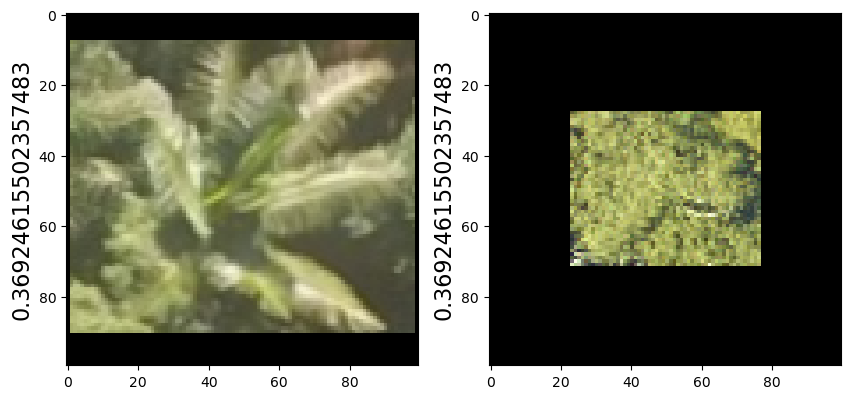

1/1 [==============================] - 0s 32ms/step


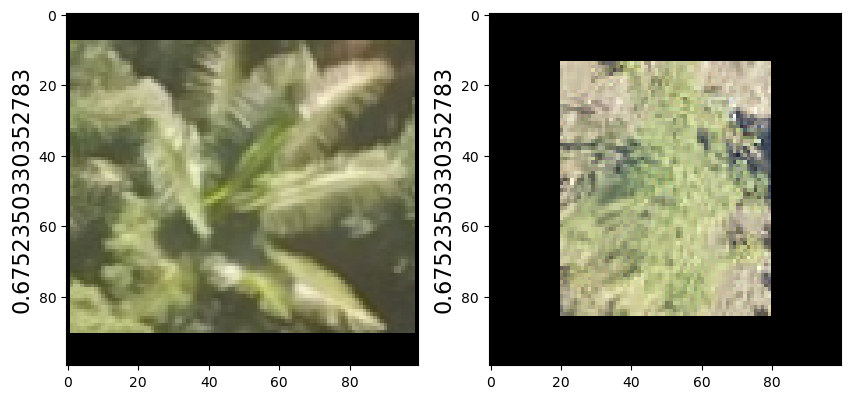

1/1 [==============================] - 0s 33ms/step


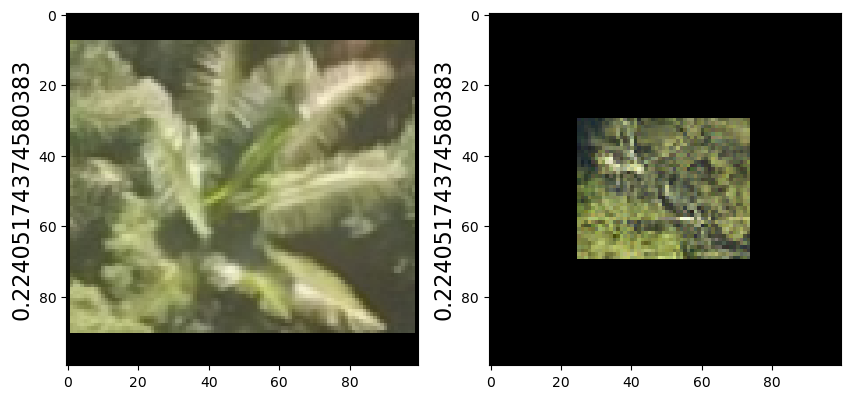

1/1 [==============================] - 0s 29ms/step


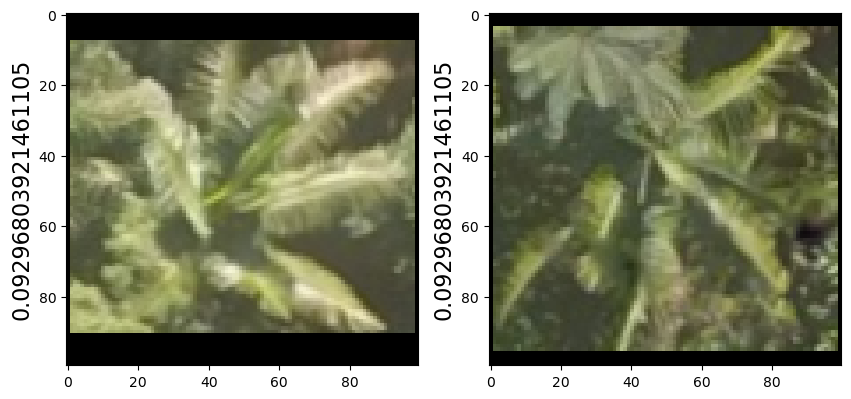

array([0.36924616, 0.67523503, 0.22405174, 0.09296804])

In [20]:
image = X_test[np.random.randint(1), :, :, :]
test_image_pairs, test_label_pairs = generate_test_image_pairs(X_tot, y_tot, image)

prediction = np.zeros(test_image_pairs.shape[0])
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction[index] = model.predict([pair_image1, pair_image2])[0][0]

    fig = plt.figure(figsize=(10, 15))
    sub = fig.add_subplot(1, 2, 1)
    plt.imshow(pair[0])
    sub.set_ylabel(prediction[index], fontsize=16)
    sub = fig.add_subplot(1, 2, 2)
    plt.imshow(pair[1])
    sub.set_ylabel(prediction[index], fontsize=16)
    plt.show()
prediction